# torchdrug

In [3]:
!pip3 install torchdrug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 200 kB 8.4 MB/s 
     |████████████████████████████████| 22.7 MB 1.5 MB/s 
     |████████████████████████████████| 108 kB 46.6 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3861159 sha256=3206551363ade185591c398a1056e933101abde2692b8108fac9718eaec9ac10
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 그래프

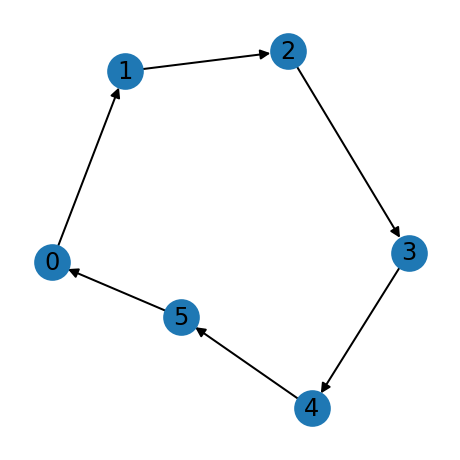

In [12]:
import torch
from torchdrug import data

edge_list = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
graph = data.Graph(edge_list, num_node=6)
graph.visualize()

In [13]:
print(graph.num_node)
print(graph.num_edge)
print(graph.edge_list)
print(graph.edge_weight)

tensor(6)
tensor(6)
tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 0]])
tensor([1., 1., 1., 1., 1., 1.])


### 에지 타입을 지정하는 경우, 세번째 인자로 지정한다

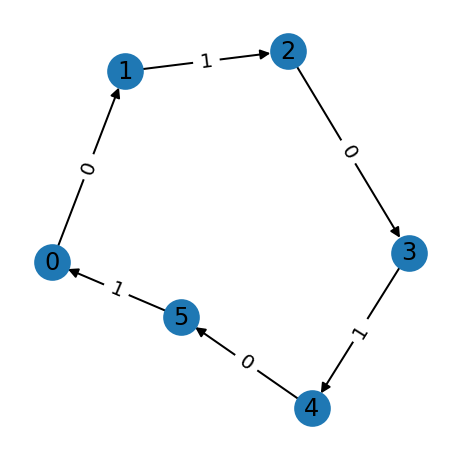

In [36]:
triplet_list = [[0, 1, 0], [1, 2, 1], [2, 3, 0], [3, 4, 1], [4, 5, 0], [5, 0, 1]]
graph = data.Graph(triplet_list, num_node=6, num_relation=2)
graph.visualize()

## 배치로 그래프 처리하기

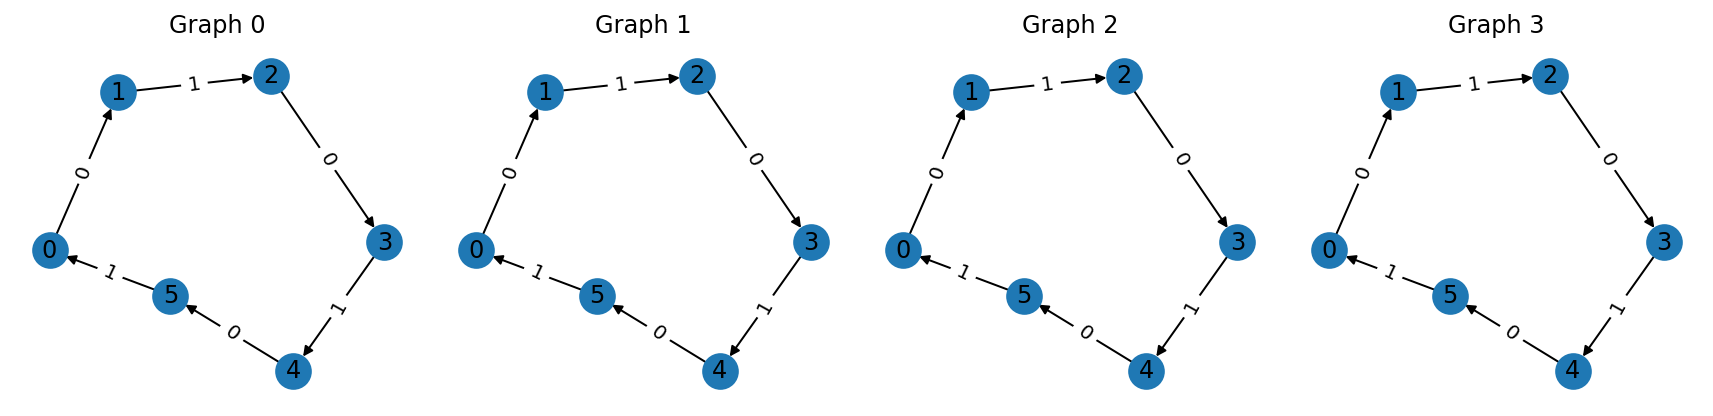

In [37]:
graphs = [graph, graph, graph, graph]
batch = data.Graph.pack(graphs)
batch.visualize(num_row=1)

In [38]:
graph = batch[1]
graphs = batch.unpack()

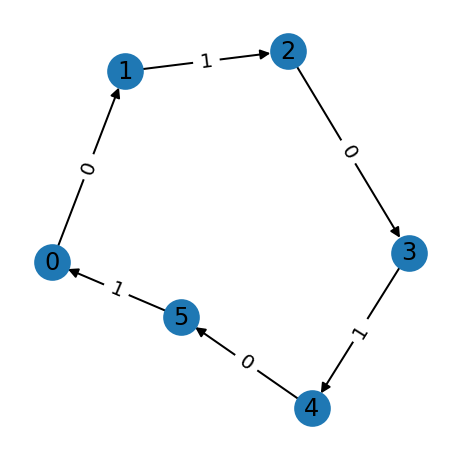

In [40]:
graph.visualize()

## Subgraph and Masking

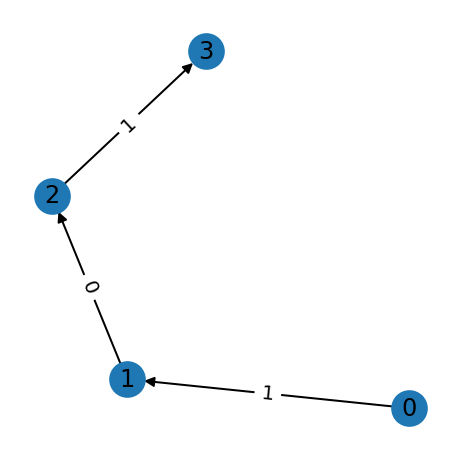

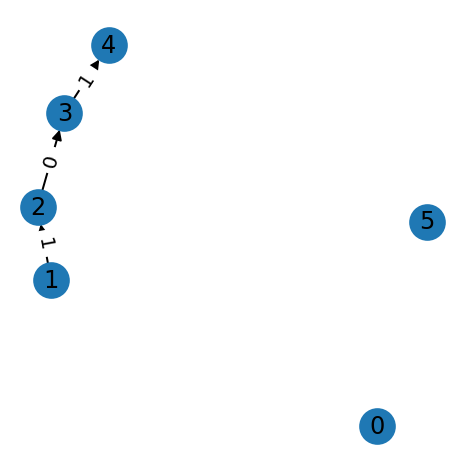

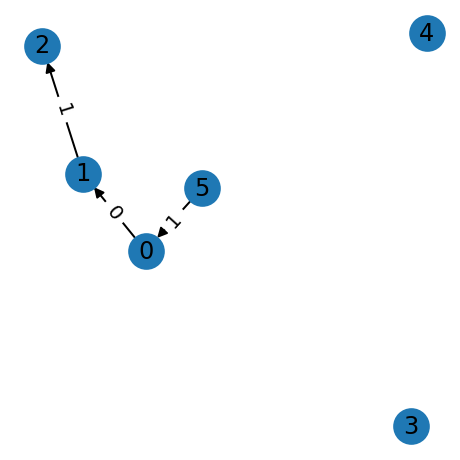

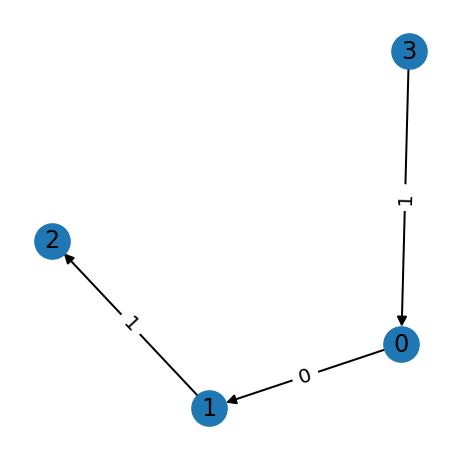

In [41]:
g1 = graph.subgraph([1, 2, 3, 4])
g1.visualize()

g2 = graph.node_mask([1, 2, 3, 4])
g2.visualize()

g3 = graph.edge_mask([0, 1, 5])
g3.visualize()

g4 = g3.compact()
g4.visualize()

## mols
- SMILES로부터 그리기

torch.Size([6, 66])
torch.Size([12, 18])


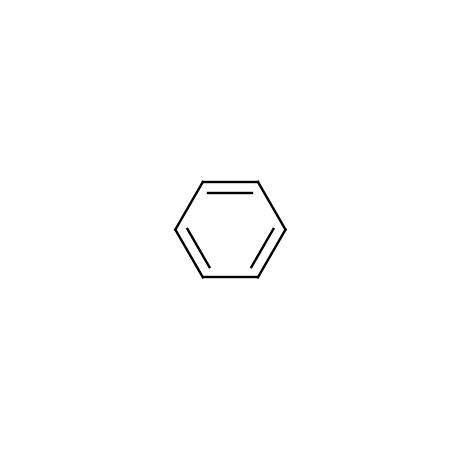

In [28]:
mol = data.Molecule.from_smiles("C1=CC=CC=C1")
mol.visualize()
print(mol.node_feature.shape)  # torch.Size([6, 69])
print(mol.edge_feature.shape)  # torch.Size([12, 19])

- CPU와 GPU 선택:  .cpu() 또는 .cuda()

PackedMolecule(batch_size=4, num_atoms=[12, 6, 14, 9], num_bonds=[22, 10, 30, 18], device='cuda:0')


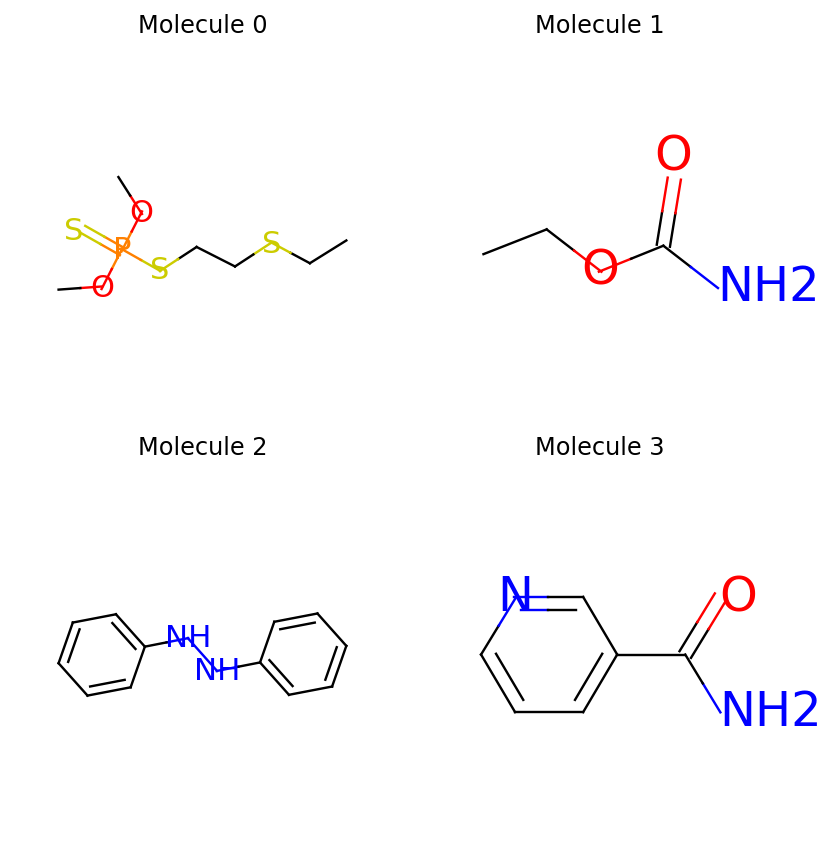

In [31]:
mols = data.PackedMolecule.from_smiles(["CCSCCSP(=S)(OC)OC", "CCOC(=O)N", 
                              "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"])
mols.visualize()
mols = mols.cuda()
print(mols)

# PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], device='cuda:0')

## 인덱싱
- node masking, edge masking or graph masking
- select edges that contain at least one carbon

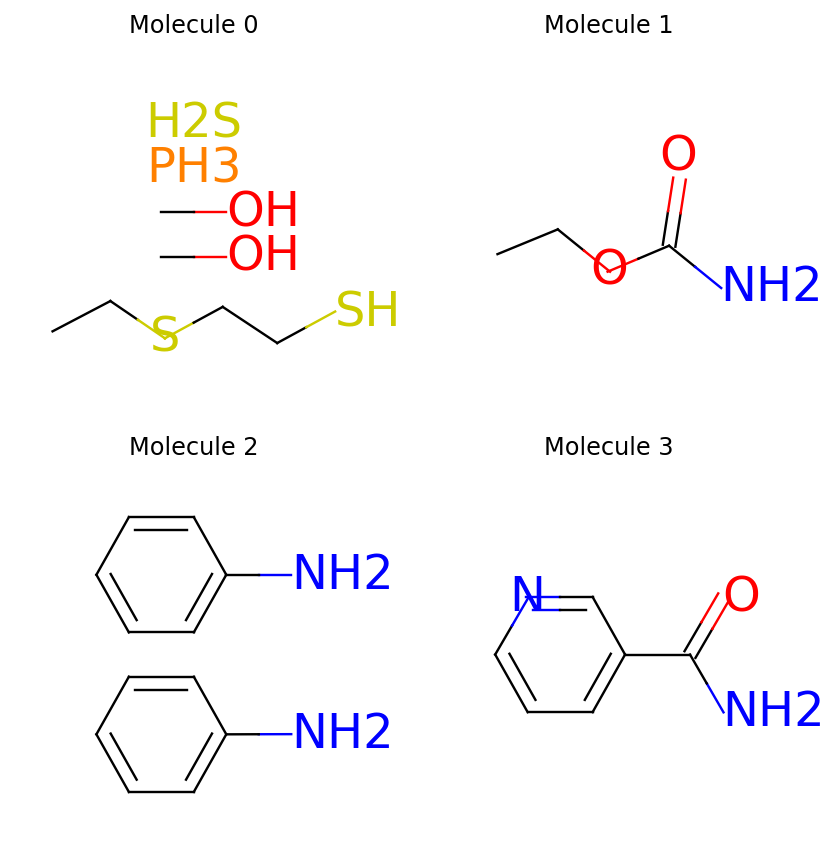

In [34]:
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

# A Molecule Classifier

## Property Prediction
- ClinTox dataset 사용
 - 임상에서 독성이 있을지를 예측, FDA 승인 여부를 알려준다
 - 1,484 샘플 제공

## 데이터 다운로드, split

In [42]:
import torch
from torchdrug import data, datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

09:45:35   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv.gz
09:45:35   Extracting /root/molecule-datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   5%|▍         | 68/1484 [00:00<00:02, 671.37it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   9%|▉         | 136/1484 [00:00<00:02, 568.20it/s]/usr/local/lib/python3.7/dist-package

In [19]:
lengths

[1182, 147, 149]

## 시각화

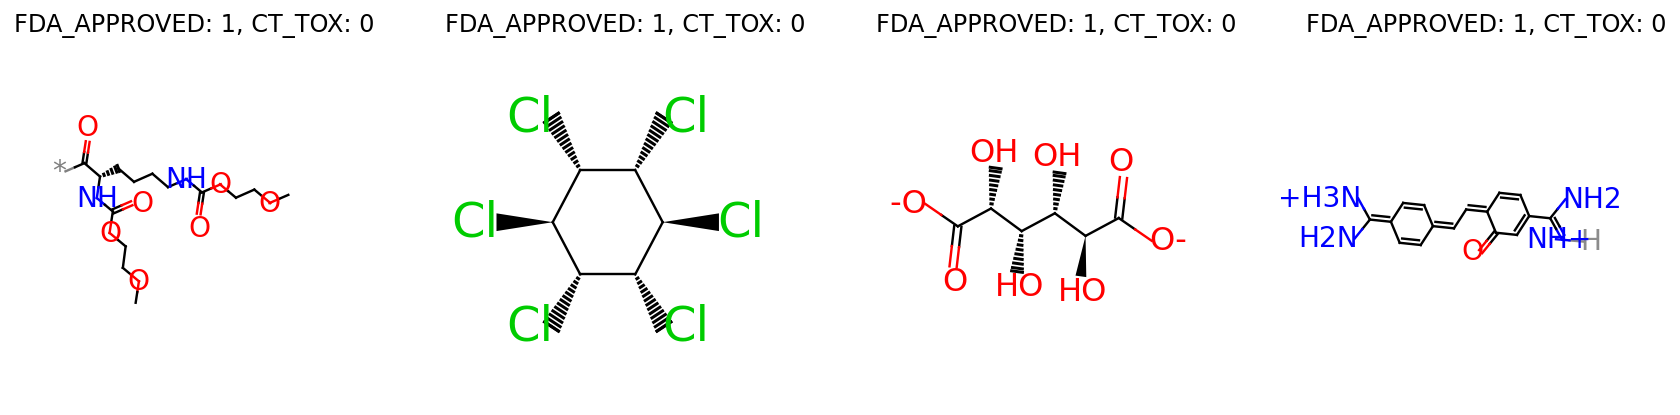

In [43]:
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

## 분류 모델
- Graph Neural Network 사용 (4개의 히든 계층)
- 이진 분류를 위해서 property prediction module 태스크를 사용
 - binary cross entropy (BCE)선택


In [48]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

## Train the Model
- optimizer 설정
- core.Engine에서 훈련과 검증 작업을 수행한다

In [63]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024, gpus=[0])
solver.train(num_epoch=100)
solver.evaluate("valid")

10:01:45   Preprocess training set
10:01:45   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'capturable': False,
               'class': 'optim.Adam',
               'eps': 1e-08,
               'foreach': None,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'metric': ('auprc', 'auroc'),
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    'eps': 0,
                    'hidden_dims': [256, 256, 256, 256],
                    'input_dim': 66,
                    'learn_eps'

{'auprc [CT_TOX]': tensor(0.6186, device='cuda:0'),
 'auprc [FDA_APPROVED]': tensor(0.9965, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.8347, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.8951, device='cuda:0')}

In [67]:
batch = data.graph_collate(valid_set[:8])
batch = utils.cuda(batch)
preds = torch.sigmoid(task.predict(batch))
torch.round(preds, decimals=2)

tensor([[1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [0.8600, 0.1300],
        [1.0000, 0.0000],
        [0.9300, 0.0100],
        [1.0000, 0.0000]], device='cuda:0', grad_fn=<RoundBackward1>)

In [68]:
targets = task.target(batch)
targets

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')

## 모델 저장과 로드
- 하이퍼파라미터: clintox_gin.json
- 파라미터: clintox_gin.pth

In [26]:
import json

with open("clintox_gin.json", "w") as fout:
    json.dump(solver.config_dict(), fout)
solver.save("clintox_gin.pth")

00:43:46   Save checkpoint to clintox_gin.pth


In [27]:
with open("clintox_gin.json", "r") as fin:
    solver = core.Configurable.load_config_dict(json.load(fin))
solver.load("clintox_gin.pth")

Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   5%|▍         | 68/1484 [00:00<00:02, 671.67it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:38: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   9%|▉         | 136/1484 [00:00<00:03, 356.80it/s]/usr/local/lib/python3.7/dist-package

00:45:40   Preprocess training set
00:45:40   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': None,
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': [0.9, 0.999],
               'capturable': False,
               'class': 'optim.Adam',
               'eps': 1e-08,
               'foreach': None,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'metric': ['auprc', 'auroc'],
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    'eps': 0,
                    'hidden_dims': [256, 256, 256, 256],
                    'input_dim': 66,
                    'learn_eps

# 그래프 신경망
- 참고: https://torchdrug.ai/docs/notes/layer.html

## 메시지 패싱 계층
- a message generation step, 
- an aggregation step 
- and a combination step.

## Readout and Broadcast 계층